## Imports and Constants

In [13]:
import os
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from PIL import Image, ImageFilter
from enum import Enum
import pandas as pd

In [14]:
NEW_FOLDER = "images_new_to_system/"
GENERATION_FOLDER = "tagged_images/"
ORIGINALS_FOLDER = "originals_in_system/"
MAPPINGS_FILE = "mapping.csv"
EXTENSION = ".png"
DECODE_INPUT = "decoding/to_check_ownership/"
DECODE_OUTPUT = "decoding/owner_labeled/"
COLOR_MAX = 255
COLOR_OFFSET = 10
COLOR_RANGE = 5

## Normalizing images

In [3]:
imgs_to_convert = os.listdir(NEW_FOLDER)
imgs_to_convert

['A.jpg',
 'Gingerbread Construction Worker.JPG',
 'IMG_20180106_184935.jpg',
 'IMG_20181019_225636987_HDR.jpg',
 'Love by the Lake- Leonid Afremov.PNG']

In [14]:
# for img_path in imgs_to_convert:
#     print(img_path)
        

20211025_140221.jpg
Gingerbread Construction Worker.JPG
IMG_20180106_184935.jpg
IMG_20181019_225636987_HDR.jpg
Love by the Lake- Leonid Afremov.PNG


In [71]:
img_path = "A.jpg"

In [76]:
# just for testing
img = np.asarray(Image.open(NEW_FOLDER + img_path)).copy()

In [52]:
# compress everything into [COLOR_OFFSET + COLOR_RANGE: 255 - COLOR_OFFSET - COLOR_RANGE]
# this way even the darkest images will be able to show negatives

In [73]:
# calculate the ranges we need to fit into
color_min = COLOR_OFFSET + COLOR_RANGE
color_max = COLOR_MAX - color_min
color_range = max_color - color_min
color_min, color_max

(15, 240)

In [74]:
# find the image minimum value and range
img_min = img.min()
img_range = img.max() - img_min

In [77]:
# if the range larger than we allow, need to squish it
if img_range > color_range:
    img -= img_min # shift down to 0
    img = img * (color_range / img_range) # scale it down
    img += min_color # shift it up to the right spot
    img = img.astype(np.uint8) # get rid of the decimals
else:
    # small enough range, just make sure it's in bounds
    if img_min < color_min:
        img += (color_min - img_min)
    else:
        # should already be perfectly in bounds
        pass

In [78]:
# find the next name for it
old_generated = os.listdir(ORIGINALS_FOLDER)
next_open = None
if len(old_generated) == 0:
    next_open = 1
else:
    next_open = 1 + max(int(name[:-4]) for name in old_generated)
next_open

1

In [79]:
# save to our folder
Image.fromarray(img).save(ORIGINALS_FOLDER + str(next_open) + EXTENSION)

In [80]:
# delete the image from the old folder
# os.remove(NEW_FOLDER + img_path)

## Encoding images

In [396]:
# get the image to work with and the name to save it under
print("Which image should we encode?")
img_name = input()
if img_name[-4:] == EXTENSION:
    img_name = img_name[:-len(EXTENSION)]
print("What name should we log it under?")
person_name = input()
"Image " + img_name + " for " + person_name

Which image should we encode?
1.png
What name should we log it under?
Pepper


'Image 1 for Pepper'

In [397]:
# just for testing
orig_img = np.asarray(Image.open(ORIGINALS_FOLDER + img_name + EXTENSION))

In [398]:
# flip the image so they're all horizontal to work with
img = orig_img.copy()
h, w, _ = img.shape
vertical = h > w
if vertical:
    img = img.T
h, w, _ = img.shape

In [15]:
# something to pick the next number
mappings = pd.read_csv(MAPPINGS_FILE)
next_tag = 1 + max(mappings[mappings["ImgNum"] == int(img_name)]["TagNum"])
print(next_tag)
mappings

NameError: name 'img_name' is not defined

In [400]:
# add the ID matched with their name
mappings = mappings.append({"Owner": person_name, "ImgNum": img_name, "TagNum": next_tag}, ignore_index=True)
mappings.tail()

,Owner,ImgNum,TagNum
0,Mick,1,0
1,Mick,1,1
2,Pepper,1,2


In [401]:
# save the new mappings
mappings.to_csv(MAPPINGS_FILE, index=False)

In [402]:
# turn the ID into ternary
class Ternary:
    def __init__(self, arg):
        if type(arg) is int:
            self.init_from_int(arg)
        elif type(arg) is tuple:
            self.init_from_trits(*arg)
        elif type(arg) is list:
            self.init_from_list(arg)
    
    def init_from_int(self, value):
        self.value = value
        self.low, self.mid, self.high = Ternary.int2tern(value)
    
    def init_from_trits(self, high, mid, low):
        self.high = high
        self.mid = mid
        self.low = low
        self.value = Ternary.tern2int(high, mid, low)
        
    def init_from_list(self, lst):
        self.high = lst[0]
        self.mid = lst[1]
        self.low = lst[2]
        self.value = Ternary.tern2int(lst[0], lst[1], lst[2])
    
    def int2tern(val):
        low = val % 3
        val = val // 3
        mid = val % 3
        val = val // 3
        high = val % 3
        return low, mid, high
        
    def tern2int(high, mid, low):
        return 9*high + 3*mid + low
    
    def __str__(self):
        return f"{self.value} (0t{self.high}{self.mid}{self.low})"

In [403]:
print(Ternary((1,2,0)))
print(Ternary([2,0,1]))
print(Ternary(11))

15 (0t120)
19 (0t201)
11 (0t102)


In [404]:
tag = Ternary(next_tag)
print(tag)

2 (0t002)


In [405]:
# write something to randomly offset
def gen_rand(high, wide, trit):
    rand = np.random.rand(high, wide, 3) * (COLOR_RANGE * 2) - COLOR_RANGE
    if trit == 1:
        rand += COLOR_OFFSET
    elif trit == 2:
        rand -= COLOR_OFFSET
#     elif trit == 0
#         rand += 0
    return rand

gen_rand(5, 4, 2)

array([[[-10.52284636,  -9.12992685,  -7.01877143],
        [ -9.23866127, -11.00222296,  -8.76609029],
        [ -6.30480655,  -9.18733778, -12.49183522],
        [-13.71481549,  -7.8228964 , -11.86247036]],

       [[-10.14000506, -12.93707697, -14.05036459],
        [ -7.78800978,  -5.9739552 , -10.00575113],
        [ -9.65868822,  -6.44935411, -13.18155736],
        [ -6.63202442,  -9.49954705, -14.20736023]],

       [[ -9.56122494, -14.10881252, -12.20090791],
        [ -7.12936868,  -7.34635859, -11.16628663],
        [ -9.49104866, -11.99492665,  -6.24556   ],
        [ -9.36944837,  -6.56293362,  -9.19854039]],

       [[-12.41704552,  -5.89223363,  -7.36766926],
        [ -7.1595802 , -14.16975314, -11.72646019],
        [ -9.78998451, -14.86872662, -12.42224903],
        [ -6.92940447, -14.72495395,  -7.59260903]],

       [[ -8.60845113,  -9.15722385, -12.7890285 ],
        [ -5.94209999, -11.53332551,  -7.22632948],
        [-14.09776415, -11.33834791, -10.67701096],
    

In [406]:
# randomly offset each section according to the ternary id
w_1_2 = w // 3
w_3 = w - 2 * w_1_2
h_1 = h // 2
h_2 = h - h_1
print("widths:", w_1_2, w_1_2, w_3)
print("heights:", h_1, h_2)

widths: 344 344 344
heights: 290 291


In [407]:
# create the randomized blocks
rand = np.zeros(img.shape)
# the control blocks
# zero / none
rand[:h_1, :w_1_2, :] = gen_rand(h_1, w_1_2, 0)
# one / positive
rand[:h_1, w_1_2:2*w_1_2, :] = gen_rand(h_1, w_1_2, 1)
# two / negative
rand[:h_1, 2*w_1_2:, :] = gen_rand(h_1, w_3, 2)
# the encoded blocks
# low
rand[h_1:, :w_1_2, :] = gen_rand(h_2, w_1_2, tag.low)
# mid
rand[h_1:, w_1_2:2*w_1_2, :] = gen_rand(h_2, w_1_2, tag.mid)
# high
rand[h_1:, 2*w_1_2:, :] = gen_rand(h_2, w_3, tag.high)

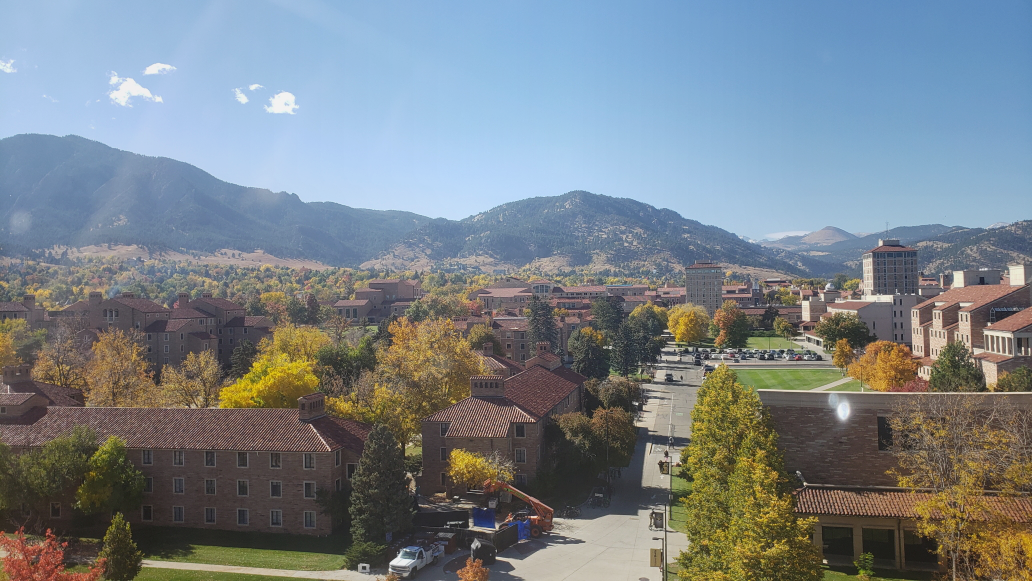

In [419]:
# blur them together
blur = Image.fromarray((rand + color_min).astype(np.uint8))
rad = min(w,h) / 5
blur = blur.filter( ImageFilter.BoxBlur(radius=rad) )
# add them to the image
done = img + np.asarray(blur) - color_min
# flip it back
if vertical:
    done = done.T
Image.fromarray(done)

In [420]:
# save the image
Image.fromarray(done).save(GENERATION_FOLDER + person_name + "_" + str(img_name) + EXTENSION)

## Decoding images

In [463]:
decode_inputs = os.listdir(DECODE_INPUT)
decode_inputs

['1.png']

In [464]:
img_name = decode_inputs[0]

In [423]:
# just for testing
orig_img = np.asarray(Image.open(DECODE_INPUT + img_name))

In [424]:
# flip the image so they're all horizontal to work with
img = orig_img.copy()
h, w, _ = img.shape
vertical = h > w
if vertical:
    img = img.T
h, w, _ = img.shape

In [426]:
# find the block sizes for this image
w_1_2 = w // 3
w_3 = w - 2 * w_1_2
h_1 = h // 2
h_2 = h - h_1
print("widths:", w_1_2, w_1_2, w_3)
print("heights:", h_1, h_2)

widths: 344 344 344
heights: 290 291


In [427]:
averages = np.zeros((2, 3), np.uint8)

In [428]:
# the control blocks
# zero / none
averages[0, 0] = img[:h_1, :w_1_2, :].mean()
# one / positive
averages[0, 1] = img[:h_1, w_1_2:2*w_1_2, :].mean()
# two / negative
averages[0, 2] = img[:h_1, 2*w_1_2:, :].mean()

In [429]:
# the encoded blocks
# low
averages[1, 0] = img[h_1:, :w_1_2, :].mean()
# mid
averages[1, 1] = img[h_1:, w_1_2:2*w_1_2, :].mean()
# high
averages[1, 2] = img[h_1:, 2*w_1_2:, :].mean()

In [430]:
wild_avgs = averages.astype(int)
wild_avgs

array([[173, 177, 157],
       [ 81,  92,  92]])

In [465]:
# do the same thing but with the original image
orig_name = img_name[img_name.rfind("_")+1:] if "_" in img_name else img_name
orig_name

'1.png'

In [432]:
# flip the image so they're all horizontal to work with
img = np.asarray(Image.open(ORIGINALS_FOLDER + orig_name)).copy()
h, w, _ = img.shape
vertical = h > w
if vertical:
    img = img.T
h, w, _ = img.shape

In [433]:
# find the block sizes for this image
w_1_2 = w // 3
w_3 = w - 2 * w_1_2
h_1 = h // 2
h_2 = h - h_1
print("widths:", w_1_2, w_1_2, w_3)
print("heights:", h_1, h_2)

widths: 344 344 344
heights: 290 291


In [434]:
averages = np.zeros((2, 3), np.uint8)
# the control blocks
# zero / none
averages[0, 0] = img[:h_1, :w_1_2, :].mean()
# one / positive
averages[0, 1] = img[:h_1, w_1_2:2*w_1_2, :].mean()
# two / negative
averages[0, 2] = img[:h_1, 2*w_1_2:, :].mean()
# the encoded blocks
# low
averages[1, 0] = img[h_1:, :w_1_2, :].mean()
# mid
averages[1, 1] = img[h_1:, w_1_2:2*w_1_2, :].mean()
# high
averages[1, 2] = img[h_1:, 2*w_1_2:, :].mean()

In [435]:
lab_avgs = averages.astype(int)
lab_avgs

array([[174, 171, 165],
       [ 90,  93,  94]])

In [436]:
delta_avgs = wild_avgs - lab_avgs
delta_avgs

array([[-1,  6, -8],
       [-9, -1, -2]])

In [437]:
# normalize it to the zero values
delta_avgs -= delta_avgs[0, 0]
delta_avgs

array([[ 0,  7, -7],
       [-8,  0, -1]])

In [438]:
# find the best match for each item
wild_tag = [abs(delta_avgs[0] - sample).argmin() for sample in delta_avgs[1]]
wild_tag = Ternary(tuple(reversed(wild_tag)))
print(wild_tag)

2 (0t002)


In [439]:
mappings = pd.read_csv(MAPPINGS_FILE)
mappings

,Owner,ImgNum,TagNum
0,Mick,1,0
1,Mick,1,1
2,Pepper,1,2


In [440]:
where_img = mappings["ImgNum"] == int(orig_name[:-len(EXTENSION)])
where_tag = mappings["TagNum"] == wild_tag.value

In [445]:
owners = mappings[where_img & where_tag]["Owner"]
assert len(owners) == 1
found_owner = owners.values[0]
found_owner

'Pepper'

In [466]:
# label the image
user_name = img_name[:-(1 + len(orig_name))]
new_name = user_name + "(Owner-" + found_owner + ")_" + orig_name
os.rename(DECODE_INPUT + img_name, DECODE_OUTPUT + new_name)

## A menu to work with it

In [113]:
class Menu(Enum):
    StandardizeImages = "Standardize the images"     # move images from new to protected, giving them numerical names
    GenerateNewID = "Generate a new tag for an image"# asks which image and the name, then associates the two together 
    CheckID = "Check the IDs for a set of images"    # goes through the decoder inputs and labels them with the owners
    Exit = "Exit"                                    # closes the program

In [63]:
menu = {str(i+1): item for i, item in enumerate(Menu)}

def check_menu():
    for option in menu:
        print(f"{option}: {menu[option].value}")
    answer = input()
    while answer not in menu:
        print("That's not a valid menu option")
        answer = input()
    return menu[answer]

check_menu()

1: Standardize the images
2: Generate a new tag for an image
3: Check the IDs for a set of images
3


<Menu.CheckID: 'Check the IDs for a set of images'>